In [4]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# from DETR.datasets.coco import *
import torch
import torchvision.transforms as T
import os
import random
import cv2
import DETR.util.misc as utils
from DETR.models import build_model
from DETR.modules.ExplanationGenerator import Generator
import argparse

In [5]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:
device = 'cuda'
args = Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
model, criterion, postprocessors = build_model(args)
model.to(device)
checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
model.load_state_dict(checkpoint['model'], strict=False)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

_IncompatibleKeys(missing_keys=[], unexpected_keys=['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.2.self_attn.in_proj_weight', 'transformer.encoder.layers.2.self_attn.in_proj_bias', 'transformer.encoder.layers.3.self_attn.in_proj_weight', 'transformer.encoder.layers.3.self_attn.in_proj_bias', 'transformer.encoder.layers.4.self_attn.in_proj_weight', 'transformer.encoder.layers.4.self_attn.in_proj_bias', 'transformer.encoder.layers.5.self_attn.in_proj_weight', 'transformer.encoder.layers.5.self_attn.in_proj_bias', 'transformer.decoder.layers.0.self_attn.in_proj_weight', 'transformer.decoder.layers.0.self_attn.in_proj_bias', 'transformer.decoder.layers.0.multihead_attn.in_proj_weight', 'transformer.decoder.layers.0.multihead_attn.in_proj_bias', 'transformer.decoder.layers.1.self_attn.in

In [72]:
def evaluate(model, gen, im, device, image_id = None):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(device)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9

    if keep.nonzero().shape[0] <= 1:
        return

    outputs['pred_boxes'] = outputs['pred_boxes'].cpu()

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    # use lists to store the outputs via up-values
    conv_features, enc_attn_weights, dec_attn_weights = [], [], []

    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        # model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        #     lambda self, input, output: enc_attn_weights.append(output[1])
        # ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    for layer in model.transformer.encoder.layers:
        hook = layer.self_attn.register_forward_hook(
            lambda self, input, output: enc_attn_weights.append(output[1])
        )
        hooks.append(hook)

    model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features = conv_features[0]
    enc_attn_weights = enc_attn_weights[-1]
    dec_attn_weights = dec_attn_weights[0]

    # get the feature map shape
    h, w = conv_features['0'].tensors.shape[-2:]
    img_np = np.array(im).astype(np.float)
    
    def show_cam_on_image(img, mask):
        mask = mask.view(1, 1, h, w)
        mask = torch.nn.functional.interpolate(mask, size=(img.shape[0], img.shape[1]), mode='bilinear')
        mask = (mask - mask.min()) / (mask.max() - mask.min())
        mask = mask.squeeze(0).squeeze(0).data.cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=3, figsize=(22, 7))
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        cam = gen.generate_ours(img, idx, use_lrp=False)
        
        # RGB heatmap
        vis = show_cam_on_image(img_np, cam)
        vis = np.uint8(255*vis)
        vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
        ax.imshow(vis)
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        
        ax = ax_i[1]
        # Just cam
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cmap = plt.cm.get_cmap('Blues').reversed()
        ax.imshow(cam.view(h, w).data.cpu().numpy(), cmap=cmap)
        ax.axis("off")
        ax.set_title(f'query id: {idx.item()}')
        
        ax = ax_i[2]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin.detach(), ymin.detach()), xmax.detach() - xmin.detach(), ymax.detach() - ymin.detach(),
                                   fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    id_str = '' if image_id == None else image_id
    fig.tight_layout()
    plt.show()

## Paper examples

In [73]:
gen = Generator(model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


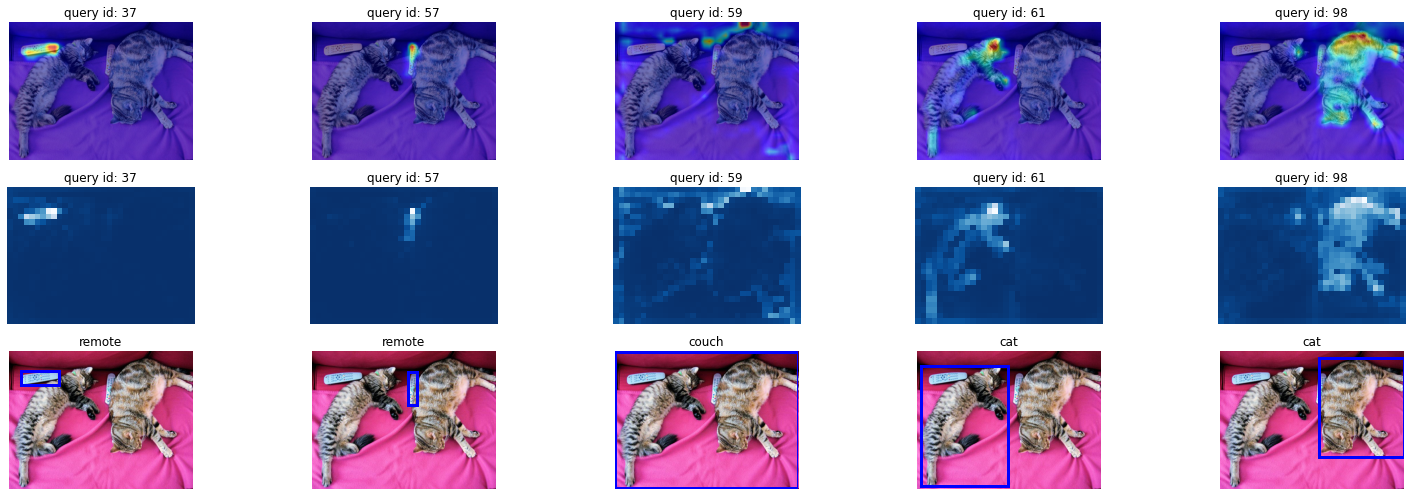

In [74]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# im.save("DETR/examples/000000039769.jpg")
im = Image.open("DETR/examples/000000039769.jpg")

evaluate(model, gen, im, 'cuda')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


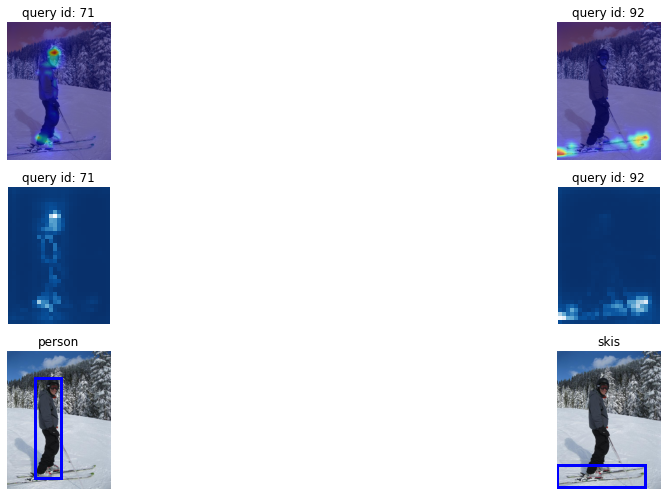

In [75]:
# url = 'http://images.cocodataset.org/val2017/000000216516.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# im.save("DETR/examples/000000216516.jpg")
im = Image.open("DETR/examples/000000216516.jpg")

evaluate(model, gen, im, 'cuda')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


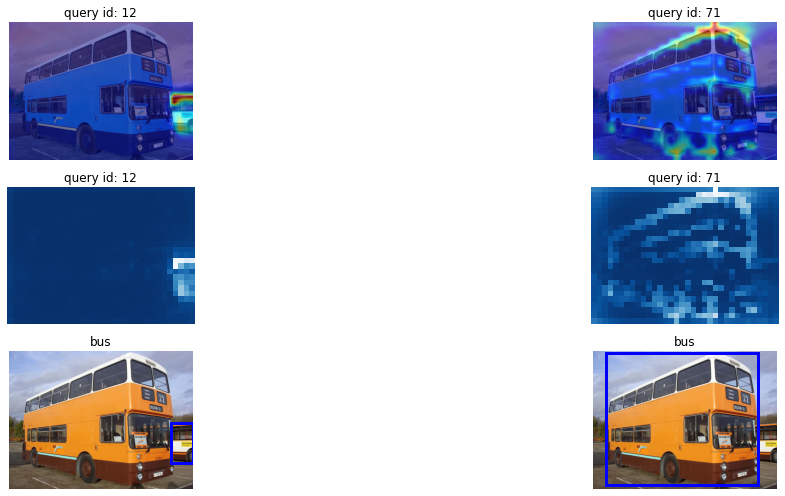

In [76]:
# url = 'http://images.cocodataset.org/val2017/000000359937.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# im.save("DETR/examples/000000359937.jpg")
im = Image.open("DETR/examples/000000359937.jpg")

evaluate(model, gen, im, 'cuda')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


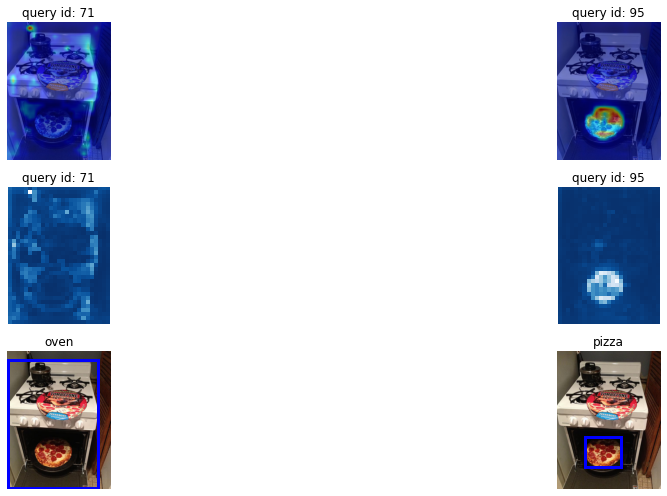

In [77]:
# url = 'http://images.cocodataset.org/val2017/000000192191.jpg'
# im = Image.open(requests.get(url, stream=True).raw)
# im.save("DETR/examples/000000192191.jpg")
im = Image.open("DETR/examples/000000192191.jpg")

evaluate(model, gen, im, 'cuda')